In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
import plotly.express as px

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import mysql.connector 
conn = mysql.connector.connect(
        host = '127.0.0.1',
        username = 'root',
        database = 'test'
        )

In [80]:
data = pd.read_sql_query('SELECT * FROM  laptop_duplicate', conn)

In [308]:
## Data assesing -- top 5 rows
pd.read_sql_query('''SELECT * FROM laptop_duplicate
                      ORDER BY `index` ASC
                      LIMIT 5''', conn)

,index,Company,TypeName,Inches,pixle_width,pixle_height,touchscreen,cpu_speed,cpu_brand,cpu_,Ram,memmory_type,primary_storage,secondary_storage,Gpu_brand,OpSys,Weight,Price
0,0,Apple,Ultrabook,13.0,2560,1600,0,2.3,Intel,Core i5,8,SSD,128,0,Intel,mac,1.4,71379
1,1,Apple,Ultrabook,13.0,1440,900,0,1.8,Intel,Core i5,8,Flash Storage,128,0,Intel,mac,1.3,47896
2,2,HP,Notebook,16.0,1920,1080,0,2.5,Intel,Core i5,8,SSD,256,0,Intel,N/A,1.9,30636
3,3,Apple,Ultrabook,15.0,2880,1800,0,2.7,Intel,Core i7,16,SSD,512,0,AMD,mac,1.8,135195
4,4,Apple,Ultrabook,13.0,2560,1600,0,3.1,Intel,Core i5,8,SSD,256,0,Intel,mac,1.4,96096


In [64]:
# bottom 5 rows
pd.read_sql_query('''SELECT * FROM laptop_duplicate
                      ORDER BY `index` DESC
                      LIMIT 5''', conn)

,index,Company,TypeName,Inches,ppi,pixle_width,pixle_height,touchscreen,cpu_speed,cpu_brand,cpu_,Ram,memmory_type,primary_storage,secondary_storage,Gpu_brand,OpSys,Weight,Price
0,1302,Asus,Notebook,16.0,97.94,1366,768,0,1.6,Intel,Celeron Dual,4,HDD,500,0,Intel,window,2.2,19660
1,1301,HP,Notebook,16.0,97.94,1366,768,0,2.5,Intel,Core i7,6,HDD,1024,0,AMD,window,2.2,40706
2,1300,Lenovo,Notebook,14.0,111.94,1366,768,0,1.6,Intel,Celeron Dual,2,Flash Storage,64,0,Intel,window,1.5,12201
3,1299,Lenovo,2 in 1 Convertible,13.0,282.42,3200,1800,1,2.5,Intel,Core i7,16,SSD,512,0,Intel,window,1.3,79867
4,1298,Lenovo,2 in 1 Convertible,14.0,157.35,1920,1080,1,2.5,Intel,Core i7,4,SSD,128,0,Intel,window,1.8,33993


# UNIVARIATE ANALYSIS 


# Company

In [244]:
# number of product available for each brand using group by 
df = pd.read_sql_query('''
SELECT Company,
COUNT(Company) AS counts
FROM laptop_duplicate
GROUP BY Company
ORDER BY counts DESC
''', conn)

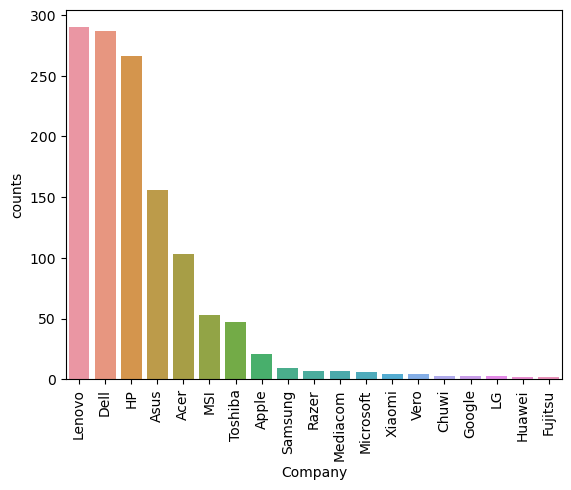

In [128]:
sns.barplot(data = df, x= 'Company', y = 'counts')
plt.xticks(rotation = 'vertical')
plt.show()

In [245]:
pd.read_sql_query(''' SELECT COUNT(*) FROM laptop_duplicate 
WHERE Company = NULL''', conn)

,COUNT(*)
0,0


### Conclusion 

We can see lenovo, dell, hp have 200+ products in market
 
No missing values in data

# TypeName

In [ ]:
# Checking the count of each type of laptop
df = pd.read_sql_query(''' SELECT TypeName, COUNT(TypeName) AS counts FROM laptop_duplicate
GROUP BY TypeName
ORDER BY counts DESC''', conn)

#Replace Netbook with Notebook
pd.read_sql_query('''
UPDATE laptop_duplicate 
SET TypeName = 'Notebook'
WHERE TypeName = 'Netbok'
''', conn)

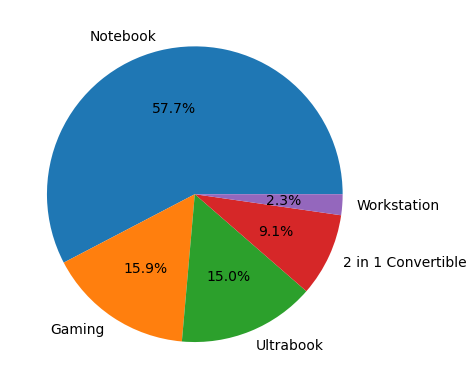

In [17]:
plt.pie(df['counts'], labels = df['TypeName'], autopct = '%0.01f%%')
plt.show()

In [247]:
# Checking null values in TypeName column
pd.read_sql_query('''SELECT COUNT(*) FROM laptop_duplicate
WHERE TypeName = NULL''', conn)

,COUNT(*)
0,0


### Conclusion

57.7% laptops in the market are Notebook 
 
Type of the laptop defines the price so this might be an important feature for us

you can check which componies are producing what type of laptops

# Inches

In [248]:
# Checking the count based on screensize
size_df = pd.read_sql_query('''SELECT Inches, COUNT(*) AS counts FROM laptop_duplicate
GROUP BY Inches
ORDER BY counts DESC''', conn)

<AxesSubplot:>

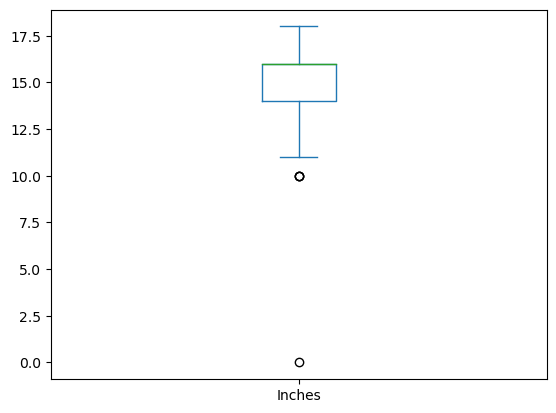

In [309]:
size_df.sort_values(by = 'Inches')
data['Inches'].plot(kind = 'box')

In [66]:
# Checking the outliers in Inches column

pd.read_sql_query('''SELECT * FROM laptop_duplicate
WHERE Inches < 1 AND Inches > 17''', conn)

Screen size can not be zero and greater than 17.

seems like lapto size greater than 18 inches that is above 20 inchesh has mistakenly wrote 2_ and 3_ instead of 1

IT can be analyze with TypeName


In [253]:
pd.read_sql_query('''
SELECT Company, TypeName,Inches,
COUNT(*) AS counts FROM laptop_duplicate
GROUP BY Company, TypeName, Inches
ORDER BY Company, counts DESC
''', conn)

,Company,TypeName,Inches,counts
0,Acer,Notebook,16.0,61
1,Acer,Notebook,14.0,9
2,Acer,Notebook,17.0,6
3,Acer,Gaming,16.0,5
4,Acer,Netbook,12.0,5
...,...,...,...,...
110,Toshiba,Ultrabook,14.0,4
111,Vero,Notebook,14.0,3
112,Vero,Notebook,13.0,1
113,Xiaomi,Notebook,16.0,2


In [ ]:
#Replacing Inches greater than 18 with the mode based on company name and Type of laptop
# mode means taking mostly repeated screen size based on perticular laptop type
pd.read_sql_query('''
UPDATE laptop_duplicate l1
SET Inches = (SELECT Inches 
                FROM laptop_duplicate l2 
                WHERE l1.Company = l2.Company AND l1.TypeName = l2.TypeName 
                GROUP BY Inches 
                ORDER BY COUNT(*) DESC   
                LIMIT 1)
WHERE Inches > 18;
''', conn)

In [326]:
size_df = pd.read_sql_query('''SELECT Inches, COUNT(*) AS counts FROM laptop_duplicate
GROUP BY Inches
ORDER BY counts DESC''', conn)
size_df

,Inches,counts
0,16.0,646
1,14.0,206
2,13.0,202
3,17.0,163
4,12.0,42
5,15.0,8
6,10.0,3
7,18.0,1
8,0.0,1
9,11.0,1


In [ ]:
#Replacing Inches eual to zero with the mode based on company name and Type of laptop
pd.read_sql_query('''
UPDATE laptop_duplicate l1
SET Inches = (SELECT Inches 
                FROM laptop_duplicate l2 
                WHERE l1.Company = l2.Company AND l1.TypeName = l2.TypeName 
                GROUP BY Inches 
                ORDER BY COUNT(*) DESC 
                LIMIT 1)
WHERE Inches = 0.0;
''', conn)

In [26]:
size_df = pd.read_sql_query('''SELECT Inches, COUNT(*) AS counts FROM laptop_duplicate
GROUP BY Inches
ORDER BY counts DESC''', conn)
size_df

,Inches,counts
0,16.0,647
1,14.0,206
2,13.0,202
3,17.0,163
4,12.0,42
5,15.0,8
6,10.0,3
7,18.0,1
8,11.0,1


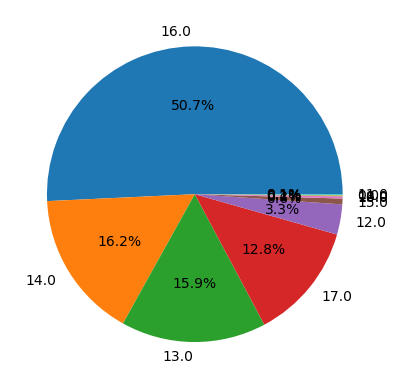

In [330]:
plt.pie(size_df['counts'], labels = size_df['Inches'], autopct = '%0.01f%%')
plt.show()

### Conclusion
More than 50% of the laptops inthe data have screensize 16 inches

# Touchscreen

In [256]:
#frequency count of touchscreen column
touchscreen_df = pd.read_sql_query('''SELECT touchscreen, COUNT(*) AS counts FROM laptop_duplicate
GROUP BY touchscreen''', conn)

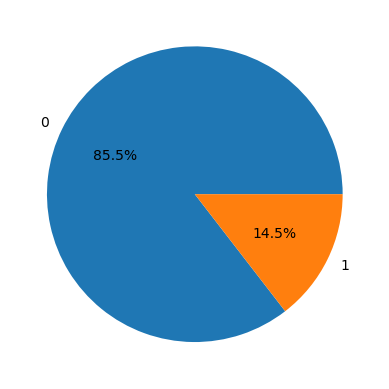

In [257]:
plt.pie(touchscreen_df['counts'], labels = touchscreen_df['touchscreen'], autopct = '%0.01f%%')
plt.show()

In [258]:
pd.read_sql_query('''SELECT COUNT(*) FROM laptop_duplicate WHERE touchscreen = NULL''', conn)

,COUNT(*)
0,0


### Conclusion

We can see only 14% laptops are touchscreen 

This column can be further analyse with TypeName and screen size

# cpu_speed

In [261]:
# Checking Central tendency, distribution and skewness of the cpu_speed column

pd.read_sql_query('''SELECT
COUNT(cpu_speed) OVER() AS counts,
MAX(cpu_speed) OVER() max_speed,
AVG(cpu_speed) OVER() AS mean,
MIN(cpu_speed) OVER() min_speed,
STD(cpu_speed) OVER() AS std,
PERCENTILE_DISC(0.25) WITHIN GROUP(ORDER BY cpu_speed) OVER() AS 'Q1',
PERCENTILE_DISC(0.5) WITHIN GROUP(ORDER BY cpu_speed) OVER() AS 'mean',
PERCENTILE_DISC(0.75) WITHIN GROUP(ORDER BY cpu_speed) OVER() AS 'Q3'
FROM laptop_duplicate
LIMIT 1
''', conn)

,counts,max_speed,mean,min_speed,std,Q1,mean,Q3
0,1273,3.6,2.298586,0.9,0.507476,2.0,2.5,2.7


<AxesSubplot:ylabel='Density'>

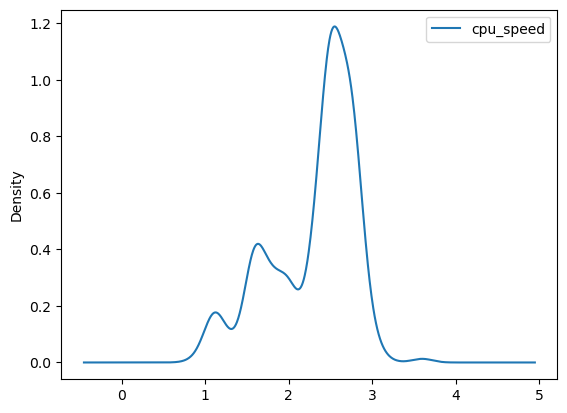

In [262]:
pd.read_sql_query('SELECT cpu_speed FROM laptop_duplicate', conn).plot(kind = 'kde')

In [263]:
#checking skewness of the data
pd.read_sql_query('SELECT cpu_speed FROM laptop_duplicate', conn).skew()

cpu_speed   -0.836929
dtype: float64

In [264]:
#checking null values in cpu_speed column
pd.read_sql_query('''SELECT COUNT(cpu_speed) FROM laptop_duplicate
                  WHERE cpu_speed = NULL''', conn)

,COUNT(cpu_speed)
0,0


### Conclusion

Graph is almost normally distributed

This column can be further analyzed by catagorizing it into 3 catagory

Also by reasearch I found that laptop price does dependent on cpu_speed

No outliers, no null values pefect column 

# cpu_brand

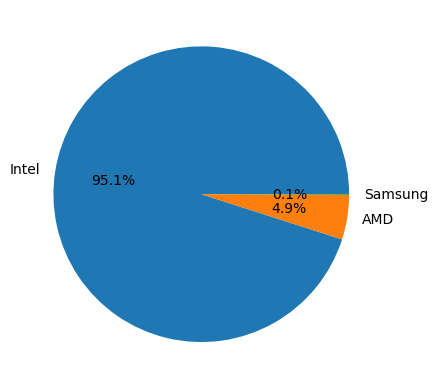

In [266]:
# frequency distribution of cpu_brand
brand_df = pd.read_sql_query('''SELECT cpu_brand, COUNT(*) AS counts FROM laptop_duplicate
GROUP BY cpu_brand
ORDER BY counts DESC''', conn)

plt.pie(brand_df['counts'], labels = brand_df['cpu_brand'], autopct = '%0.01f%%')
plt.show()

In [267]:
#checking null values of cpu_brand column
pd.read_sql_query('''SELECT COUNT(*) FROM laptop_duplicate WHERE cpu_brand = NULL''', conn)

,COUNT(*)
0,0


### Conclusion

95% of laptop have cpu_brand intel


# cpu_

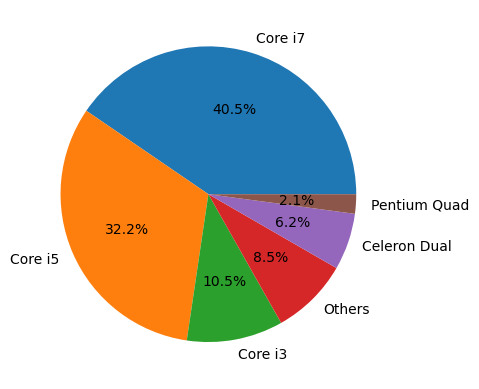

In [269]:
#Reducing catagories in cpu_ column by putting least repeated values in 'others' cataogory,to analyze this column in better way

cpu_df = pd.read_sql_query('''SELECT 
CASE 
  WHEN cpu_ = 'Core i7' THEN 'Core i7'
  WHEN cpu_ = 'Core i5' THEN 'Core i5'
  WHEN cpu_ = 'Core i3' THEN 'Core i3'
  WHEN cpu_ = 'Celeron Dual' THEN 'Celeron Dual'
  WHEN cpu_ = 'Pentium Quad' THEN 'Pentium Quad'
  ELSE 'Others'
END AS cpu_new, COUNT(*) AS counts
FROM laptop_duplicate
GROUP BY cpu_new
ORDER BY counts DESC
''', conn)

plt.pie(cpu_df['counts'],labels =  cpu_df['cpu_new'], autopct = '%0.01f%%')
plt.show()

In [270]:
# checking null values in cpu_ column
pd.read_sql_query('''SELECT COUNT(*) FROM laptop_duplicate WHERE cpu_ = NULL''', conn)

,COUNT(*)
0,0


### Conclusion

We can see majority i.e 40% of the laptops have cpu_ Core i7 and Core i5

# Ram

In [67]:
#Frequencu distribution of RAM
ram_df = pd.read_sql_query('''SELECT Ram, 
COUNT(*) / SUM(COUNT(*)) OVER()*100 AS percentage
FROM laptop_duplicate
GROUP BY Ram
ORDER BY percentage DESC''', conn)


<AxesSubplot:xlabel='Ram', ylabel='percentage'>

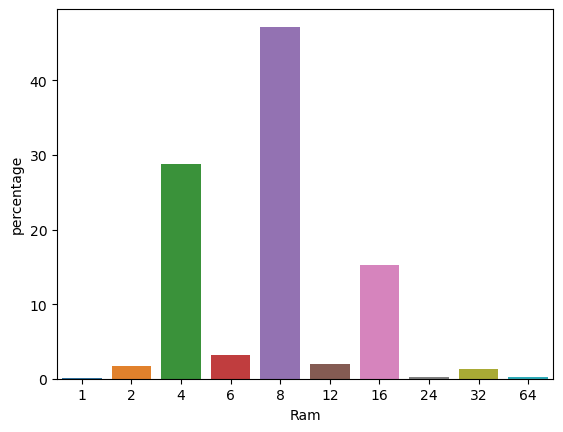

In [273]:
sns.barplot(data = ram_df, x = 'Ram', y = 'percentage')

In [274]:
#Checking null values in RAM column
pd.read_sql_query('''SELECT COUNT(*) FROM laptop_duplicate WHERE Ram = NULL''', conn)

,COUNT(*)
0,0


### Conclusion

We can see more than 40% of the laptops in a market have Ram 8GB 

Also there are many 4GB and 16GB laptops are present in market

# Memmory type

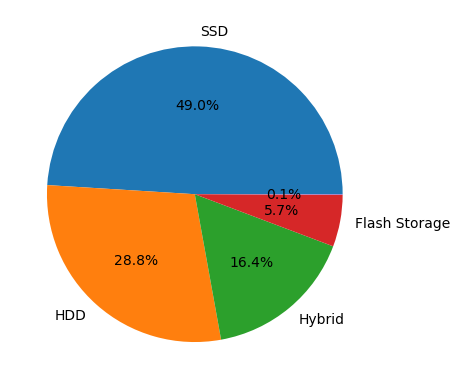

In [276]:
#Frequency distribution of memmory type
memory_df = pd.read_sql_query('''SELECT memmory_type, COUNT(*) AS counts FROM laptop_duplicate
GROUP BY memmory_type
ORDER BY counts DESC''',conn)

plt.pie(memory_df['counts'], labels = memory_df['memmory_type'], autopct = '%0.01f%%')
plt.show()

In [6]:
#Checking null values 
pd.read_sql_query('''SELECT *  FROM laptop_duplicate
WHERE memmory_type = "" 
''',conn)

,index,Company,TypeName,Inches,pixle_width,pixle_height,touchscreen,cpu_speed,cpu_brand,cpu_,Ram,memmory_type,primary_storage,secondary_storage,Gpu_brand,OpSys,Weight,Price
0,770,Dell,Notebook,16.0,1920,1080,0,2.7,Intel,Core i7,16,,0,0,AMD,window,2.3,62938


### Conclusion

Almost 50% of the laptops have ssd

There are null values in the data (sisce memmory types are dependent on price, storage capacity we will fill up this values using knn imputation)

# Primary storage

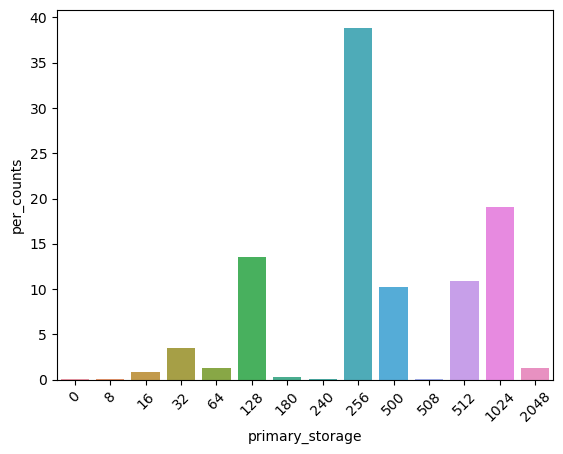

In [279]:
p_storage_df = pd.read_sql_query('''
SELECT primary_storage,
COUNT(*)/ sum(COUNT(*)) OVER()*100 AS per_counts 
FROM laptop_duplicate
GROUP BY primary_storage
ORDER BY per_counts DESC
''', conn)

sns.barplot(data = p_storage_df, x = 'primary_storage', y = 'per_counts')
plt.xticks(rotation = '45')
plt.show()

# Conclusion

40% of the laptops have primary storage of 256 GB

We can see some values are not standard, actually they are std it's just they are represented it in different way 
because of storage for system recovery or caching.

There is one missing value in the data

# Secondary storage

In [68]:
s_storage_df = pd.read_sql_query('''
SELECT secondary_storage,
COUNT(*)/ sum(COUNT(*)) OVER()*100 AS per_counts 
FROM laptop_duplicate
GROUP BY secondary_storage
ORDER BY per_counts DESC
''', conn)


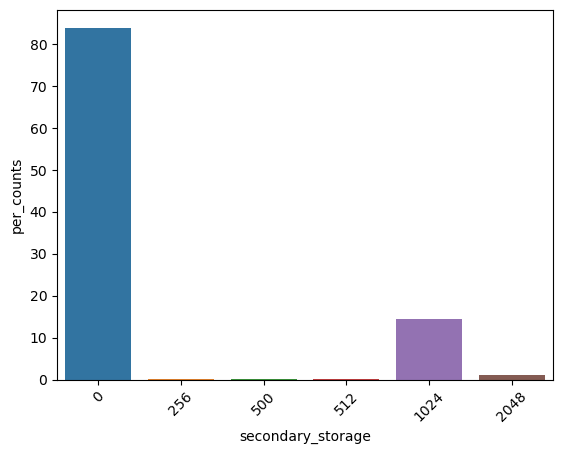

In [282]:
sns.barplot(data = s_storage_df, x = 'secondary_storage', y = 'per_counts')
plt.xticks(rotation = '45')
plt.show()

### Conclusion

80% of the laptops do not have secondary storage option 

14% laptops do have extra 1024 gb storage option 

# Gpu_brand

In [69]:
gpu_df = pd.read_sql_query('''SELECT Gpu_brand, COUNT(*) AS counts FROM laptop_duplicate
GROUP BY Gpu_brand''', conn)

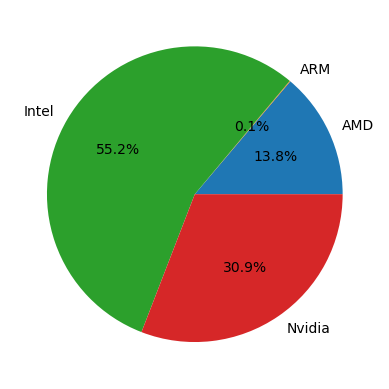

In [285]:
plt.pie(gpu_df['counts'], labels = gpu_df['Gpu_brand'], autopct = '%0.01f%%')
plt.show()

In [8]:
pd.read_sql_query('''SELECT Gpu_brand FROM laptop_duplicate
WHERE Gpu_brand = NULL
''', conn)

,Gpu_brand


### Conclusion

55% laptops have graphics processing unit of Intel 

# opsys

In [70]:

opsys_df = pd.read_sql_query('''SELECT OpSys, COUNT(*) AS counts FROM laptop_duplicate
GROUP BY OpSys''', conn)

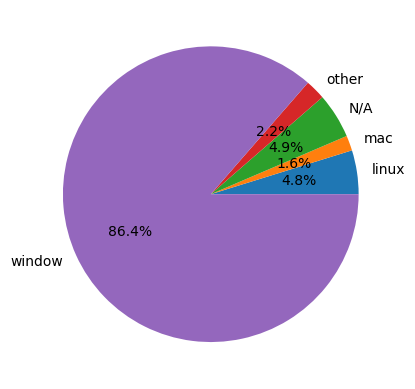

In [288]:
plt.pie(opsys_df['counts'],labels = opsys_df['OpSys'], autopct = '%0.01f%%')
plt.show()

In [9]:
pd.read_sql_query('''SELECT * FROM laptop_duplicate WHERE OpSys = "N/A"
''', conn).head()

,index,Company,TypeName,Inches,pixle_width,pixle_height,touchscreen,cpu_speed,cpu_brand,cpu_,Ram,memmory_type,primary_storage,secondary_storage,Gpu_brand,OpSys,Weight,Price
0,2,HP,Notebook,16.0,1920,1080,0,2.5,Intel,Core i5,8,SSD,256,0,Intel,N/A,1.9,30636
1,10,HP,Notebook,16.0,1366,768,0,2.5,Intel,Core i5,4,HDD,500,0,Intel,N/A,1.9,20987
2,11,HP,Notebook,16.0,1920,1080,0,2.0,Intel,Core i3,4,HDD,500,0,Intel,N/A,1.9,18381
3,18,Lenovo,Notebook,16.0,1920,1080,0,2.4,Intel,Core i3,8,HDD,1024,0,Nvidia,N/A,2.2,26587
4,22,HP,Notebook,16.0,1366,768,0,1.5,AMD,E-Series E2-9000e,4,HDD,500,0,AMD,N/A,1.9,13746


### Conclusion

Almost 87% of the laptops have windows operating system 

5% values are NULL in the data

# weight


 outliers are present in the weight column where some weights are 0 which is not possible.

Also there are rows where weight is more than 5 kg. Thise is not possible because all laptops are either notebook or ultranotebook 
so it is possible that this weights are written in reverse order or in kg 

We will replace them with avg weight based on company name and TypeName

In [ ]:
#Replace values greater than 5 with avg weight based on compony name and type of laptop 
pd.read_sql_query('''
UPDATE laptop_duplicate l1
SET Weight = (SELECT AVG(Weight) FROM laptop_duplicate l2
              WHERE l1.Company = l2.Company AND l1.TypeName = l2.TypeName)
WHERE l1.Weight>5
''', conn)

In [ ]:
#Replace values where weight is zero with avg weight based on compony name and type of laptop 
pd.read_sql_query('''
UPDATE laptop_duplicate l1
SET Weight = (SELECT AVG(Weight) FROM laptop_duplicate l2
              WHERE l1.Company = l2.Company AND l1.TypeName = l2.TypeName)
WHERE l1.Weight = 0
''', conn)

In [291]:
# checking descriptive statistic
pd.read_sql_query('''
SELECT 
MIN(Weight) OVER() AS min_,
AVG(Weight) OVER() AS mean_,
MAX(Weight) OVER() AS max_,
PERCENTILE_DISC(0.25) WITHIN GROUP(ORDER BY Weight) OVER() AS 'Q1',
PERCENTILE_DISC(0.5) WITHIN GROUP(ORDER BY Weight) OVER() AS 'median',
PERCENTILE_DISC(0.75) WITHIN GROUP(ORDER BY Weight) OVER() AS 'Q3'
FROM laptop_duplicate
LIMIT 1
''', conn)

,min_,mean_,max_,Q1,median,Q3
0,0.7,2.048108,4.7,1.5,2.0,2.3


<AxesSubplot:ylabel='Density'>

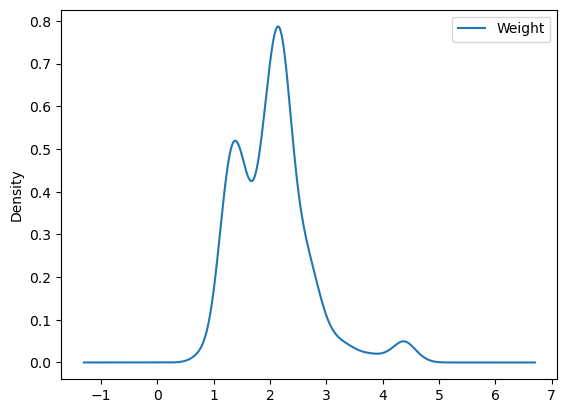

In [301]:
pd.read_sql_query('''
SELECT Weight FROM laptop_duplicate
''', conn).plot(kind = 'kde')

In [13]:
pd.read_sql_query('''SELECT Weight FROM laptop_duplicate''', conn).skew()

Weight    1.160743
dtype: float64

In [77]:
weight_df = pd.read_sql_query('''
SELECT TypeName , AVG(Weight) FROM laptop_duplicate
GROUP BY TypeName
''', conn)
weight_df

,TypeName,AVG(Weight)
0,2 in 1 Convertible,1.585345
1,Gaming,2.953202
2,Notebook,2.037191
3,Ultrabook,1.345774
4,Workstation,2.465517


### Conclusion

Data is positively skewed 


# price

In [295]:
#Checking the distribution and skewness of price column
pd.read_sql_query('''
SELECT 
MIN(Price) OVER() AS min_,
AVG(Price) OVER() AS mean,
MAX(Price) OVER() AS max_,
STD(Price) OVER() AS std_,
PERCENTILE_DISC(0.25) WITHIN GROUP(ORDER BY Price) OVER() AS 'Q1',
PERCENTILE_DISC(0.5) WITHIN GROUP(ORDER BY Price) OVER() AS 'median',
PERCENTILE_DISC(0.75) WITHIN GROUP(ORDER BY Price) OVER() AS 'Q3'
FROM laptop_duplicate
LIMIT 1
''', conn)

,min_,mean,max_,std_,Q1,median,Q3
0,9271,59955.8712,324955,37317.6036,31915,52161,79333


In [296]:
pd.read_sql_query('''
SELECT * FROM laptop_duplicate
WHERE Price < 10000
''', conn)

,index,Company,TypeName,Inches,pixle_width,pixle_height,touchscreen,cpu_speed,cpu_brand,cpu_,Ram,memmory_type,primary_storage,secondary_storage,Gpu_brand,OpSys,Weight,Price
0,1215,Acer,Netbook,12.0,1366,768,0,1.5,Intel,Celeron Dual,2,SSD,32,0,Intel,other,1.3,9271


<AxesSubplot:ylabel='Density'>

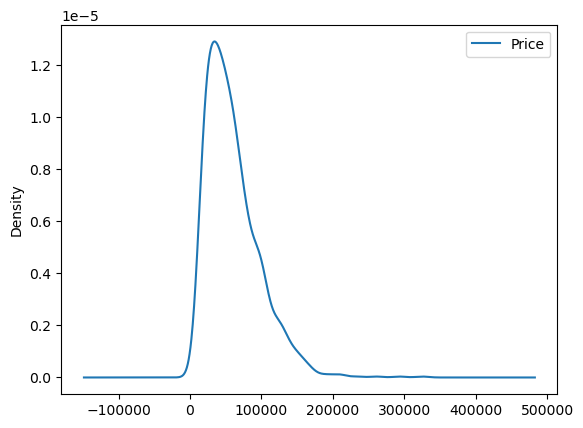

In [297]:
pd.read_sql_query('''
SELECT Price FROM laptop_duplicate
''', conn).plot(kind = 'kde')

In [298]:
pd.read_sql_query('''
SELECT Price FROM laptop_duplicate
''', conn).skew()

Price    1.52978
dtype: float64

In [299]:
pd.read_sql_query('''
SELECT Price FROM laptop_duplicate
WHERE Price = NULL
''', conn)

,Price


### Conclusion

There are some laptops whose price too high(above 200000) ot too low (9271) but this are not ouliers as thier features are justifying their price

Distribution of the data is positively skewed 

# BIVARIATE ANALYSIS

### Company-Price

In [28]:
# Find the average price of all the laptop Company 
#(Note thate we are considering only those brands who have more than 10 laptops in the data)

compony_price = pd.read_sql_query('''
SELECT Company, AVG(Price) AS avg_price FROM laptop_duplicate
GROUP BY Company
HAVING COUNT(*)>10
ORDER BY avg_price DESC
''', conn)

<BarContainer object of 8 artists>

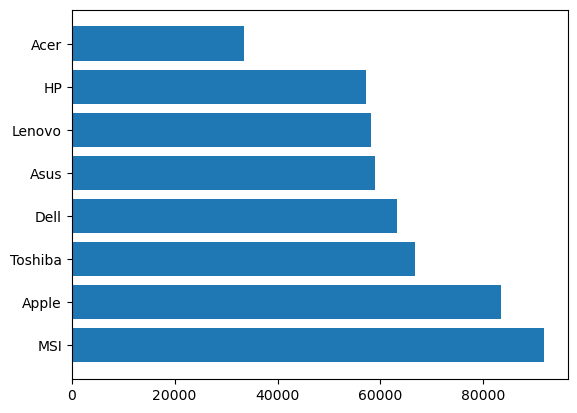

In [29]:
plt.barh(compony_price['Company'], compony_price['avg_price'])

### Conclusion 

We can see that Acer is providing the budget laptops and it's avg price is 25K.

HP, Lenovo, Asus, Toshiba, Dell comes into Medium range laptops and there price is about 65k.

Apple and MSI falls under high range catagory with avg price is above 80k.

# TypeName - Price

In [18]:
#Avg price of laptop based on laptop type
typname_price = pd.read_sql_query('''
SELECT TypeName, AVG(Price) AS avg_price
FROM laptop_duplicate
GROUP BY TypeName
ORDER BY avg_price DESC
''', conn)
typname_price

,TypeName,avg_price
0,Workstation,121497.5862
1,Gaming,92204.4039
2,Ultrabook,82926.1204
3,2 in 1 Convertible,68186.8621
4,Notebook,41327.4319


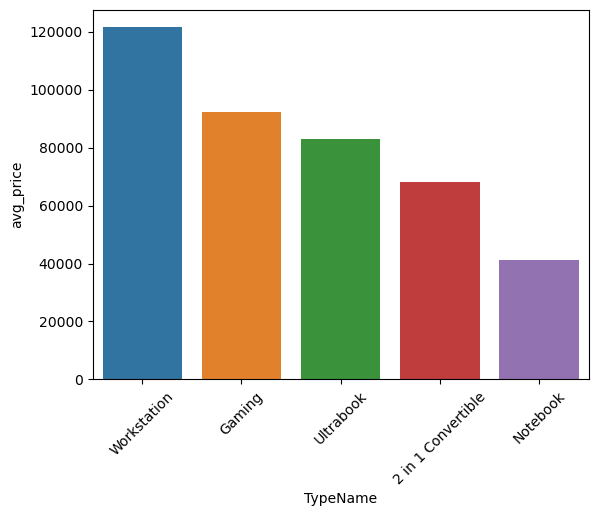

In [118]:
sns.barplot(data = typname_price, x = 'TypeName', y = 'avg_price')
plt.xticks(rotation = '45')
plt.show()

### Conclusion

We can see price is higly dependent on laptop type.

Workstation type laptops are higher end laptops where as Notebook laptops are lower end laptops

# Inches - Price

In [28]:
#Avg price of laptop based on screen size
inches_price = pd.read_sql_query(''' 
SELECT Inches, AVG(Price) AS avg_price
FROM laptop_duplicate
GROUP BY Inches
ORDER BY avg_price DESC
''', conn)
inches_price

,Inches,avg_price
0,18.0,149131.0000
1,15.0,105437.2500
2,17.0,88279.7791
3,13.0,73596.7574
4,11.0,69211.0000
5,14.0,64606.9515
6,16.0,48255.8393
7,12.0,33001.6667
8,10.0,29735.0000


In [35]:
#To analyze this column properly we will catagories this column
laptop_size_df = pd.read_sql_query('''
SELECT 
CASE 
  WHEN Inches<=12 AND Inches >=11 THEN 'small'
  WHEN Inches<=14 AND Inches >=13 THEN 'mediam'
  WHEN Inches<=16 AND Inches >=15 THEN 'large'
  ELSE 'very_large'
END AS laptop_size,
Price FROM laptop_duplicate
''', conn)

<AxesSubplot:xlabel='laptop_size'>

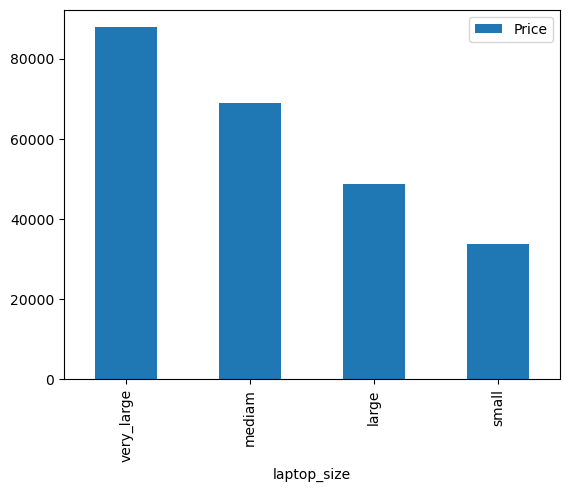

In [46]:
laptop_size_df.groupby('laptop_size').mean('Price').sort_values(by = 'Price', ascending = False).plot(kind = 'bar')

### Conclusion 

We can see laptop price higly dependent on laptop screen size

suprisingly medium size laptops are more expensive as compare to large laptops 

This can be further analyze with other column to understand why it is like that

# touchcsreen - price

<AxesSubplot:xlabel='touchscreen', ylabel='avg_price'>

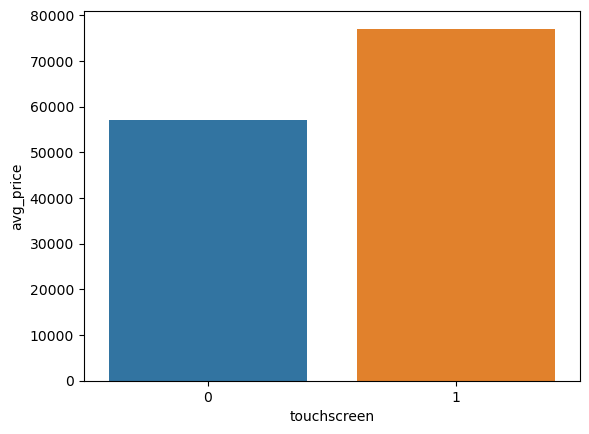

In [53]:
touchscreen_price = pd.read_sql_query('''
SELECT touchscreen , AVG(Price) AS avg_price
FROM laptop_duplicate 
GROUP BY touchscreen 
ORDER BY avg_price DESC
''', conn)

sns.barplot(data = touchscreen_price, x = 'touchscreen', y = 'avg_price')

### Conclusion 

Avereage price of screen touch laptop is high as compare to non-screen touch laptops

# cpu_speed - price

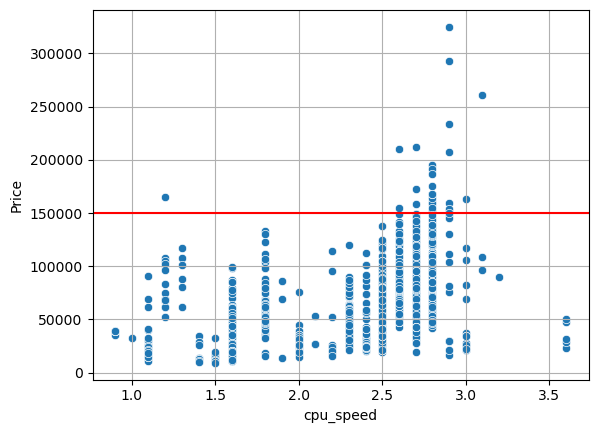

In [68]:
cpuspeed_price = pd.read_sql_query('''
SELECT cpu_speed, AVG(Price) AS avg_price FROM laptop_duplicate
GROUP BY cpu_speed
ORDER BY avg_price DESC
''', conn)

sns.scatterplot(data = data, x = 'cpu_speed', y = 'Price')
plt.grid()
plt.axhline(y =  150000, color = 'red')

### Conclusion 

Even thogh price is not much define by cpu_speed but
we can see almost all the laptops whoes price is above 1500000 has cpu_speed between 2.5 and 3

# cpu_brand - Price

In [75]:
cpu_brand_price = pd.read_sql_query('''
SELECT cpu_brand, AVG(Price) AS avg_price
FROM laptop_duplicate 
GROUP BY cpu_brand 
HAVING COUNT(*) > 10
ORDER BY avg_price DESC
''', conn)
cpu_brand_price

,cpu_brand,avg_price
0,Intel,61517.9479
1,AMD,29870.8871


<AxesSubplot:xlabel='cpu_brand', ylabel='avg_price'>

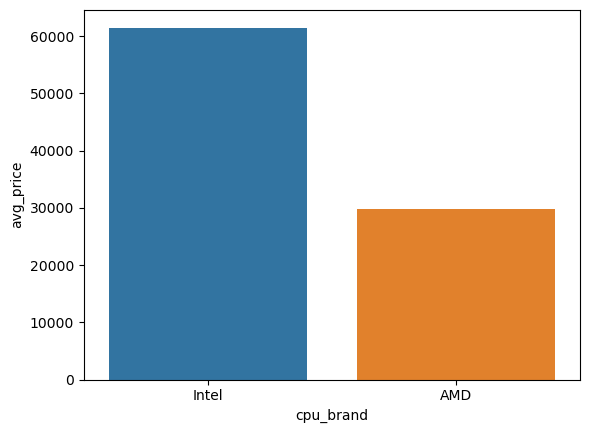

In [76]:
sns.barplot(data = cpu_brand_price, x = 'cpu_brand', y = 'avg_price')

### Conclusion 

Laptops having cpu brand Intel are almost double in price as compare to AMD

# cpu_ - Price

In [80]:
cpu_df = pd.read_sql_query('''SELECT 
CASE 
  WHEN cpu_ = 'Core i7' THEN 'Core i7'
  WHEN cpu_ = 'Core i5' THEN 'Core i5'
  WHEN cpu_ = 'Core i3' THEN 'Core i3'
  WHEN cpu_ = 'Celeron Dual' THEN 'Celeron Dual'
  WHEN cpu_ = 'Pentium Quad' THEN 'Pentium Quad'
  ELSE 'Others'
END AS cpu_new, AVG(Price) AS avg_price
FROM laptop_duplicate
GROUP BY cpu_new
ORDER BY avg_price DESC
''', conn)
cpu_df

,cpu_new,avg_price
0,Core i7,85147.6408
1,Core i5,54230.5780
2,Others,41102.5278
3,Core i3,28927.5373
4,Pentium Quad,22437.3704
5,Celeron Dual,16671.8987


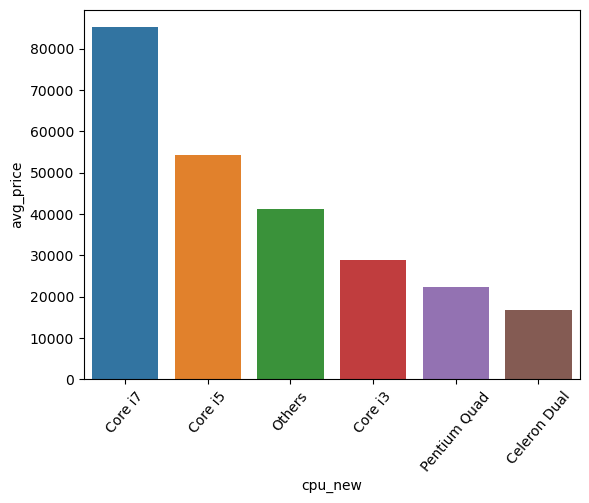

In [83]:
sns.barplot(data = cpu_df, x = 'cpu_new', y = 'avg_price')
plt.xticks(rotation = '50')
plt.show()

### Conclusion 

Core i7 have the highest average price i.e 80k

Core i5 and others have mediam avg price i.e 45k - 55k

Core i3, pentium quad and celeron dual have lowest avg price i.e 20k - 30k

# Ram - Price

In [88]:
ram_price = pd.read_sql_query('''
SELECT Ram, AVG(Price) AS avg_price FROM laptop_duplicate
GROUP BY Ram 
HAVING COUNT(*) > 5
ORDER BY avg_price DESC
''', conn)
ram_price

,Ram,avg_price
0,32,181849.3529
1,16,103158.3454
2,12,66037.4800
3,8,63160.8569
4,6,32826.5250
5,4,30552.9210
6,2,14756.8182


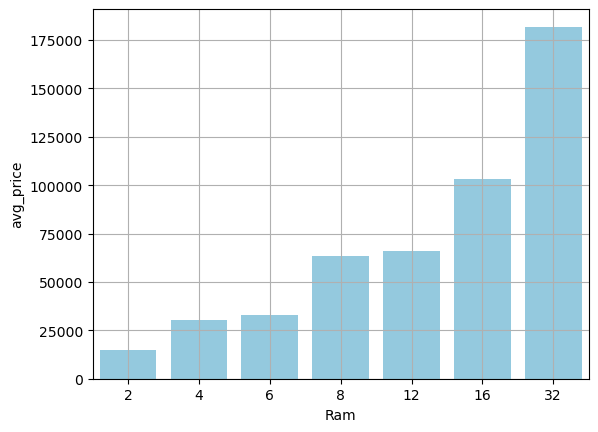

In [93]:
sns.barplot(data = ram_price, x = 'Ram', y = 'avg_price', color = 'skyblue')
plt.grid()

### Conclusion 

Price is higly correlated with Ram 

Higer the Ram greater the Price

# Memmory_type - Price

In [78]:
memmory_price = pd.read_sql_query('''
SELECT memmory_type, AVG(Price) AS avg_price FROM laptop_duplicate
GROUP BY memmory_type
ORDER BY avg_price DESC
''', conn)

<AxesSubplot:xlabel='memmory_type', ylabel='avg_price'>

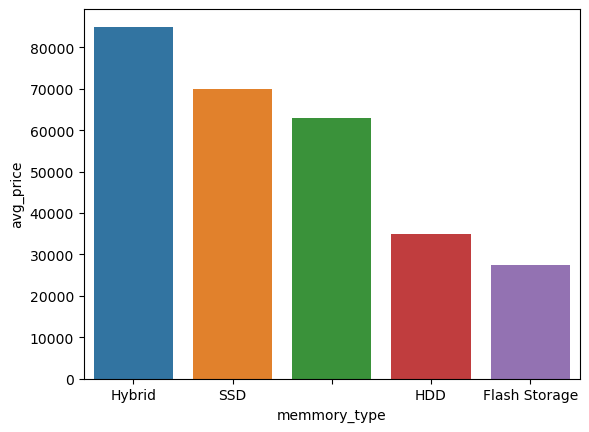

In [97]:
sns.barplot(data = memmory_price, x = 'memmory_type', y = 'avg_price')

### Conclusion 

Laptp price is dependent on memmory_type 

Laptops having hybrid memmory have higest average price followed by ssd, hdd and flash storage

laptops having memmory type flash storage have lowest average price

# Primary_storage - Price

In [100]:
pd.read_sql_query('''
SELECT primary_storage, AVG(Price) AS avg_price FROM laptop_duplicate
GROUP BY primary_storage
HAVING COUNT(*) > 10
ORDER BY avg_price DESC
''', conn)

,primary_storage,avg_price
0,512,102547.6522
1,256,71061.4404
2,128,54063.5723
3,1024,44255.3663
4,2048,34563.4375
5,500,33581.9308
6,64,28262.1875
7,32,16377.7727


# Secondary_storage - Price

In [105]:
pd.read_sql_query('''
SELECT secondary_storage, AVG(Price) AS avg_price FROM laptop_duplicate
GROUP BY secondary_storage
HAVING COUNT(*) > 5
ORDER BY avg_price DESC
''', conn)

,secondary_storage,avg_price
0,1024,87356.6667
1,2048,81206.1333
2,0,54870.9850


# Weight - Price

<AxesSubplot:xlabel='Weight', ylabel='Price'>

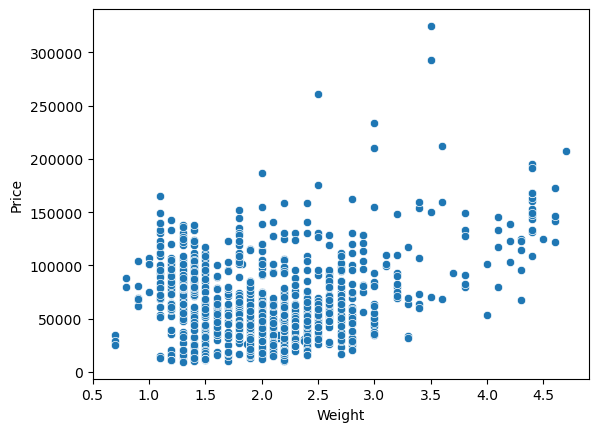

In [108]:
weight_price = pd.read_sql_query('''
SELECT Weight, Price FROM laptop_duplicate
''', conn)

sns.scatterplot(data = weight_price , x = 'Weight', y = 'Price')

In [116]:
# we can analyze this column in better way if we convert it in catagory 

weight_price = pd.read_sql_query('''
SELECT t.weight_cat, AVG(t.Price) AS avg_price FROM (SELECT 
                                                CASE 
                                                   WHEN Weight <=1.4 AND Weight >=0.9 THEN 'ultrathin'
                                                   WHEN Weight <=1.8 AND Weight >1.4 THEN 'thin'
                                                   WHEN Weight <=2.7 AND Weight >1.8 THEN 'mainstream'
                                                   ELSE 'heavy'
                                                END AS weight_cat,
                                                Price FROM laptop_duplicate) AS t
GROUP BY t.weight_cat
HAVING COUNT(*) > 10
ORDER BY avg_price DESC
''', conn)

<AxesSubplot:xlabel='weight_cat', ylabel='avg_price'>

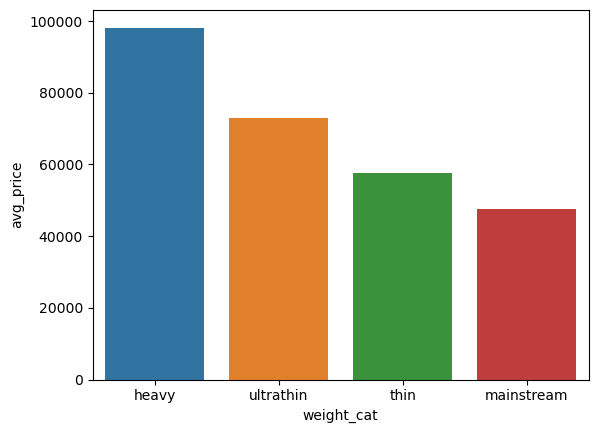

In [117]:
sns.barplot(data = weight_price, x = 'weight_cat', y = 'avg_price')

### Conclusion

Light weight laptops are costlier as compare to heavy laptops 

but we can see heavy laptops have higest average price we need to analyze further to understand this behaviour

<AxesSubplot:>

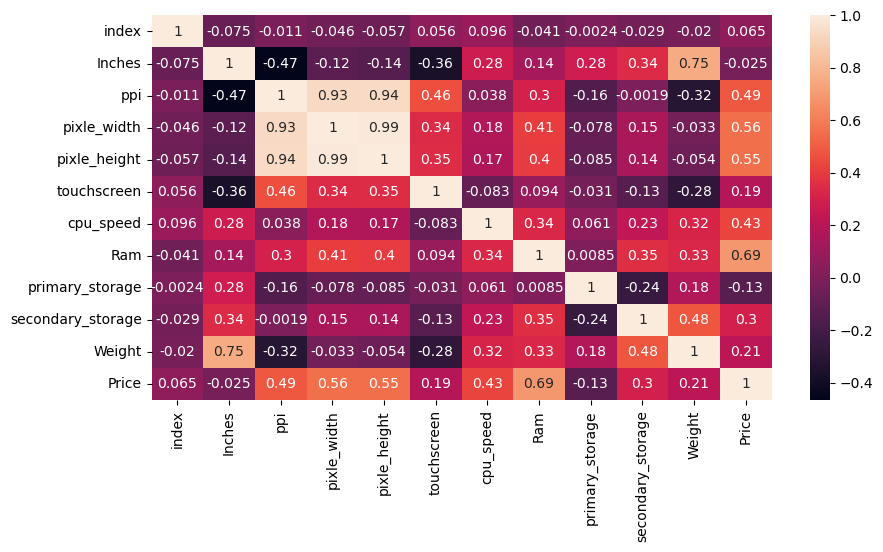

In [81]:
# Checking the correlation 
plt.figure(figsize = (10,5))
sns.heatmap(data.corr(), annot = True)

# touchscreen_typename

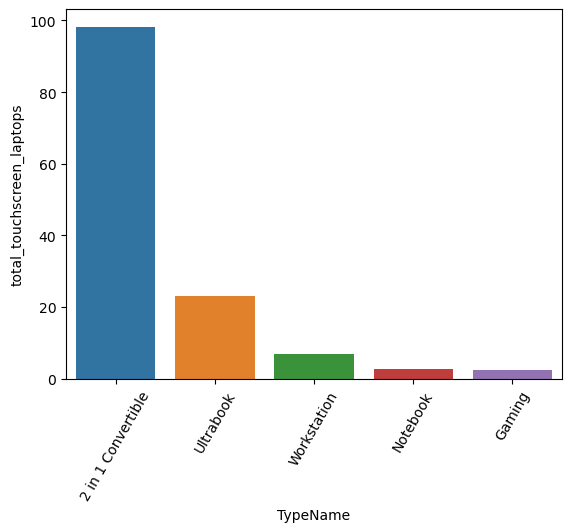

In [303]:
#checking frequency of touch screen laptops in percentage in each laptop type
touchscreen_typename = pd.read_sql_query('''
SELECT TypeName, 
SUM(touchscreen)/COUNT(*)*100  AS total_touchscreen_laptops
FROM laptop_duplicate
GROUP BY TypeName
ORDER BY total_touchscreen_laptops DESC
''', conn)

sns.barplot(data = touchscreen_typename, x = 'TypeName', y = 'total_touchscreen_laptops')
plt.xticks(rotation = '60')
plt.show()

### Conclusion 

Almost 98% of laptops in the 2 in 1 converible catagory are touchscreen which is higest amon all the catagory

# TypeName - Ram

In [82]:
# Finding what is the most common ram in different types of laptps has beeen used
pd.read_sql_query('''
SELECT TypeName, RAM, percent_ FROM (SELECT t.TypeName , t.RAM,  

                            COUNT(*)/AVG(t.counts)*100 AS percent_,                             
                            DENSE_RANK() OVER(PARTITION BY t.TypeName ORDER BY COUNT(*) DESC) AS row_number                             
                            FROM (SELECT TypeName,Ram, COUNT(*) OVER(PARTITION BY TypeName) AS counts FROM laptop_duplicate) AS t
                            GROUP BY t.TypeName , t.RAM) AS t1
WHERE row_number = 1
ORDER BY percent_ DESC
''', conn)

#grouping based on typname and ram and finding count for each ram value for all the TypeName 
#giving rank based on count of ram in descending order using DENSE_RANK windows function 
#selecting only those ram value where rank is 1 which indicates most reapeated value in the data
#dividing this value with total number of laptops present in that perticular laptop type 
#to understand what percentage of laptops in the data have that perticular RAM value

,TypeName,RAM,percent_
0,Ultrabook,8,70.6806
1,Workstation,8,68.9655
2,2 in 1 Convertible,8,50.8621
3,Gaming,16,47.7833
4,Notebook,4,44.4142


### Conclusion 

Almost 70 % of the laptops in Ultrabook and Workstation catagories has RAM 8GB

Almost 48% laptops in Gaming catagory has RAM 16GB

50% laptops in a Convertible catagory has RAM 8GB

44% Laptops in Notebook catagory has RAM 4GB


# Multivariate Analysis 

# Company - TypeName - Price

<AxesSubplot:ylabel='Company'>

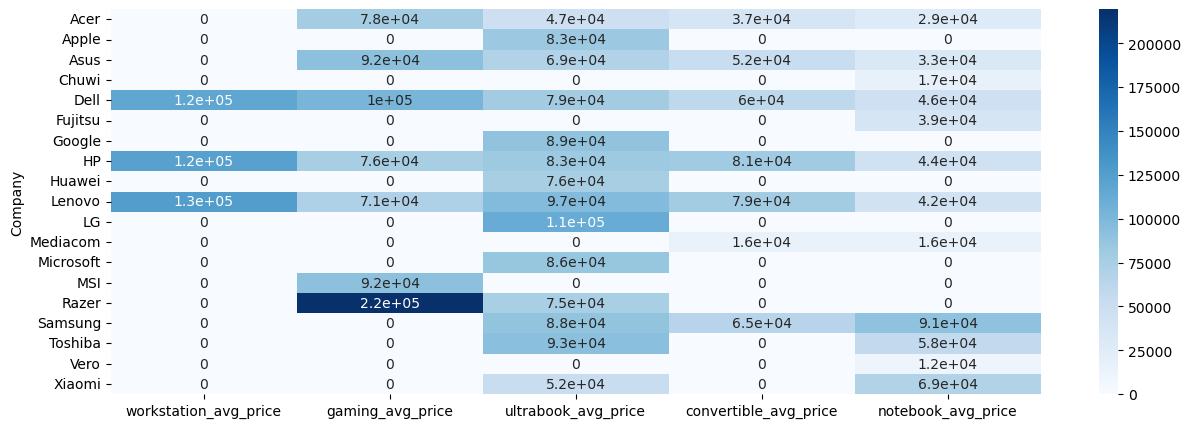

In [196]:
# Creating a pivot table in which values incicates average price of laptop of perticular compay in perticular catagory
pivot_t = pd.read_sql_query('''
SELECT Company,
AVG(CASE WHEN TypeName = 'workstation' THEN Price END) AS 'workstation_avg_price',
AVG(CASE WHEN TypeName = 'Gaming' THEN Price END) AS 'gaming_avg_price',
AVG(CASE WHEN TypeName = 'Ultrabook' THEN Price END) AS 'ultrabook_avg_price',
AVG(CASE WHEN TypeName = '2 in 1 Convertible' THEN Price END) AS 'convertible_avg_price',
AVG(CASE WHEN TypeName = 'Notebook' THEN Price END) AS 'notebook_avg_price'
FROM laptop_duplicate
GROUP BY Company 
''', conn)

plt.figure(figsize = (15, 5))
sns.heatmap(pivot_t.set_index('Company').fillna(0), annot = True, cmap = 'Blues')

### Conclusion

In workstation type laptops Lenovo is costliest laptop

In gaming type laptop Razer has highest price Where as Lenovo has lowest price

In ultrabook LG is expensive where as Acer is lowest in price

In convertible type laptop HP has higest price where has Accer has lowest price 

In Notebook type laptop Samsun has higest price where as mediacom has lowest price

# Company - TypeName - counts

<AxesSubplot:ylabel='Company'>

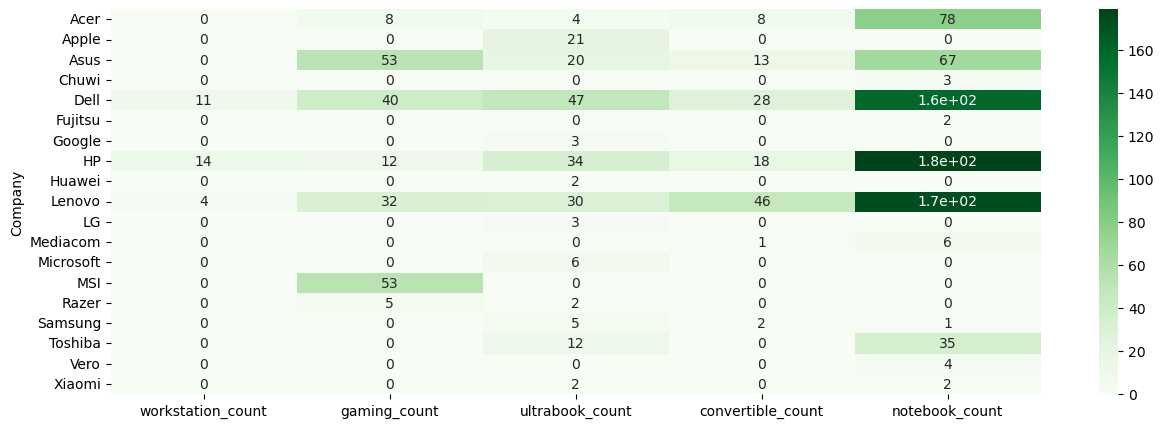

In [201]:
# Creating a pivot table in which values incicates total number of laptops of perticular compay in perticular catagory

pivot_t = pd.read_sql_query('''
SELECT Company,
SUM(CASE WHEN TypeName = 'workstation' THEN 1 END) AS 'workstation_count',
SUM(CASE WHEN TypeName = 'Gaming' THEN 1 END) AS 'gaming_count',
SUM(CASE WHEN TypeName = 'Ultrabook' THEN 1 END) AS 'ultrabook_count',
SUM(CASE WHEN TypeName = '2 in 1 Convertible' THEN 1 END) AS 'convertible_count',
SUM(CASE WHEN TypeName = 'Notebook' THEN 1 END) AS 'notebook_count'
FROM laptop_duplicate
GROUP BY Company 
''', conn)

plt.figure(figsize = (15, 5))
sns.heatmap(pivot_t.set_index('Company').fillna(0), annot = True, cmap="Greens")

### Conclusion 

Workstation and Notebook HP has higest products in data 

Gaming Asus and MSI has higest products in the data

Ultrabook Dell has higest number of laptops

Convertible Lenovo has higest number of products

# TypeName - Inches - Weight

In [250]:
type_inches_weight = pd.read_sql_query('''
SELECT TypeName, AVG(Inches) AS size, AVG(Weight) AS weight FROM laptop_duplicate
GROUP BY TypeName
ORDER BY size DESC, weight DESC
''', conn)

type_inches_weight

,TypeName,size,weight
0,Gaming,16.408867,2.953202
1,Workstation,15.655172,2.465517
2,Notebook,15.444142,2.037191
3,2 in 1 Convertible,13.620690,1.585345
4,Ultrabook,13.607330,1.345774


### Conclusion

We can see that Ultrabook laptot type is the most compact laptop type, where as Gaming laptop type is the bulky 



# Feature Engineering

#### creating new feature ppi using pixle width, pixle height and screen size column

In [ ]:
pd.read_sql_query('''
ALTER TABLE laptop_duplicate ADD COLUMN ppi DECIMAL(10,2) AFTER Inches
''', conn)

In [ ]:
pd.read_sql_query('''
UPDATE laptop_duplicate 
SET ppi = (SQRT(pixle_width*pixle_width + pixle_height*pixle_height) / Inches)
''', conn)

In [22]:
pd.read_sql_query('SELECT * FROM laptop_duplicate', conn)

,index,Company,TypeName,Inches,ppi,pixle_width,pixle_height,touchscreen,cpu_speed,cpu_brand,cpu_,Ram,memmory_type,primary_storage,secondary_storage,Gpu_brand,OpSys,Weight,Price
0,0,Apple,Ultrabook,13.0,232.22,2560,1600,0,2.3,Intel,Core i5,8,SSD,128,0,Intel,mac,1.4,71379
1,1,Apple,Ultrabook,13.0,130.62,1440,900,0,1.8,Intel,Core i5,8,Flash Storage,128,0,Intel,mac,1.3,47896
2,2,HP,Notebook,16.0,137.68,1920,1080,0,2.5,Intel,Core i5,8,SSD,256,0,Intel,N/A,1.9,30636
3,3,Apple,Ultrabook,15.0,226.42,2880,1800,0,2.7,Intel,Core i7,16,SSD,512,0,AMD,mac,1.8,135195
4,4,Apple,Ultrabook,13.0,232.22,2560,1600,0,3.1,Intel,Core i5,8,SSD,256,0,Intel,mac,1.4,96096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268,1298,Lenovo,2 in 1 Convertible,14.0,157.35,1920,1080,1,2.5,Intel,Core i7,4,SSD,128,0,Intel,window,1.8,33993
1269,1299,Lenovo,2 in 1 Convertible,13.0,282.42,3200,1800,1,2.5,Intel,Core i7,16,SSD,512,0,Intel,window,1.3,79867
1270,1300,Lenovo,Notebook,14.0,111.94,1366,768,0,1.6,Intel,Celeron Dual,2,Flash Storage,64,0,Intel,window,1.5,12201
1271,1301,HP,Notebook,16.0,97.94,1366,768,0,2.5,Intel,Core i7,6,HDD,1024,0,AMD,window,2.2,40706


# ppi - TypeName

<AxesSubplot:xlabel='touchscreen', ylabel='avg_ppi'>

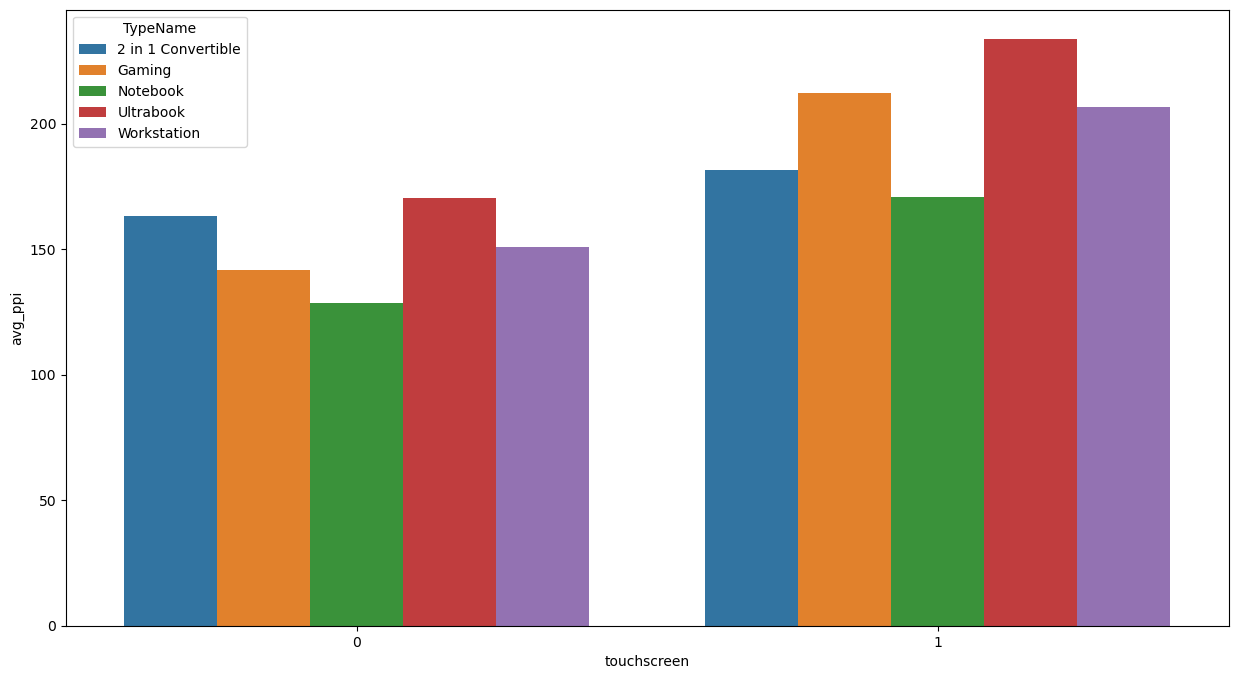

In [25]:
new_df = pd.read_sql_query('''
SELECT touchscreen,TypeName, AVG(ppi) AS avg_ppi FROM laptop_duplicate
GROUP BY touchscreen, TypeName
''', conn)

plt.figure(figsize = (15,8))
sns.barplot(data = new_df, x = 'touchscreen', y = 'avg_ppi', hue = 'TypeName')


### Conclusion 

Avg ppi for touch screen laptop of all the catagory is higher than non touch screen laptops

<AxesSubplot:xlabel='TypeName', ylabel='avg_ppi'>

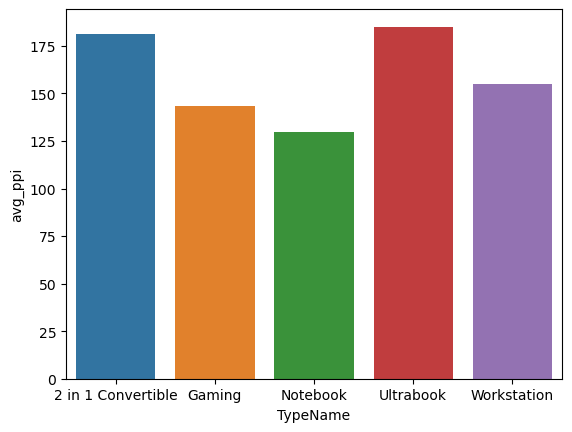

In [26]:
new_df_1 = pd.read_sql_query('''
SELECT TypeName, AVG(ppi) AS avg_ppi FROM laptop_duplicate
GROUP BY  TypeName
''', conn)

sns.barplot(data = new_df_1, x = 'TypeName', y = 'avg_ppi')

### Conclusion 

convertible and ultrabook laptops have higest average ppi while notebook have lowest average ppi

In [86]:
data.isnull().sum()

index                0
Company              0
TypeName             0
Inches               0
ppi                  1
pixle_width          0
pixle_height         0
touchscreen          0
cpu_speed            0
cpu_brand            0
cpu_                 0
Ram                  0
memmory_type         0
primary_storage      0
secondary_storage    0
Gpu_brand            0
OpSys                0
Weight               0
Price                0
dtype: int64

In [ ]:
pd.read_sql_query('''
UPDATE laptop_duplicate
SET memmory_type = ''
WHERE memmory_type = 'N/A'
''')

In [97]:
data = pd.read_sql_query('''
SELECT * FROM laptop_duplicate
''', conn)
data[data['ppi'].isnull()]

,index,Company,TypeName,Inches,ppi,pixle_width,pixle_height,touchscreen,cpu_speed,cpu_brand,cpu_,Ram,memmory_type,primary_storage,secondary_storage,Gpu_brand,OpSys,Weight,Price
465,476,Dell,Workstation,0.0,NaN,1920,1080,0,2.8,Intel,Core i7,8,SSD,256,0,Nvidia,window,1.8,128298
